In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
import re
import random
import matplotlib.pyplot as plt

device = torch.device('cuda')
print(f"Using device: {device}")

Using device: cuda


In [2]:
def load_and_split_stories(file_path):
    """Загрузка и разделение историй по токену <|endoftext|>"""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    stories = [story.strip() for story in content.split('<|endoftext|>') if story.strip()] # strip выкидывает лишние пробелы
    return stories

# Загрузка данных
train_stories = load_and_split_stories('tiny_stories_train.txt')
test_stories = load_and_split_stories('tiny_stories_test.txt')

print(f"{len(train_stories)} train")
print(f"{len(test_stories)} test")

24 train
22 test


In [3]:
class TextProcessor:
    def __init__(self):
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_size = 0
        
    def build_vocab(self, texts, min_freq=1):
        counter = Counter()
        for text in texts:
            tokens = re.findall(r'\w+|[^\w\s]', text.lower())
            counter.update(tokens)
        
        vocab = ['<PAD>', '<UNK>', '<|endoftext|>'] # нужны для единообразия данных
        # <PAD> - для выравнивания длины последовательностей
        # <UNK> - слова в тексте, которые не встречаются в словаре модели
        # BOS и EOS не нужны т.к. данные уже разделены endoftext 
        for word, freq in counter.items():
            if freq >= min_freq:
                vocab.append(word)
        
        self.word_to_idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx_to_word = {idx: word for idx, word in enumerate(vocab)}
        self.vocab_size = len(vocab)
        print(f"Vocabulary size: {self.vocab_size}")
        
    def text_to_sequence(self, text, max_length=None):
        tokens = re.findall(r'\w+|[^\w\s]', text.lower())
        
        sequence = [self.word_to_idx.get(token, self.word_to_idx['<UNK>']) for token in tokens]
        
        if max_length:
            if len(sequence) < max_length:
                sequence = sequence + [self.word_to_idx['<PAD>']] * (max_length - len(sequence))
            else:
                sequence = sequence[:max_length]
                
        return sequence

In [4]:
def prepare_beginning_ending_pairs_1(stories):
    beginnings = []
    endings = []

    for story in stories:
        tokens = re.findall(r'\w+|[^\w\s]', story.lower())
        if len(tokens) < 4:
            continue
        
        half = len(tokens) // 2
        beginning = tokens[:half]
        ending = tokens[half:]

        beginnings.append(' '.join(beginning))
        endings.append(' '.join(ending))

    return beginnings, endings

def prepare_beginning_ending_pairs(stories):
    beginnings = []
    endings = []

    for story in stories:
        # токенизация
        tokens = re.findall(r'\w+|[^\w\s]', story.lower())

        # если история слишком маленькая — пропускаем
        if len(tokens) < 2:
            continue
        
        # вход: все токены, кроме последнего
        input_seq = tokens[:-1]

        # цель: все токены, кроме первого
        target_seq = tokens[1:]
        
        beginnings.append(' '.join(input_seq))
        endings.append(' '.join(target_seq))
    
    return beginnings, endings


# Создаем процессор и строим словарь
processor = TextProcessor()
processor.build_vocab(train_stories, min_freq=1)

# Подготавливаем данные для обучения
train_inputs, train_targets = prepare_beginning_ending_pairs(train_stories)
print(f"Prepared {len(train_inputs)} training sequences")

Vocabulary size: 552
Prepared 24 training sequences


In [5]:
class SingleHeadAttention(nn.Module): 
    # Self-attention позволяет модели в каждом положении (каждом токене)
    # учитывать все предыдущие токены контекста, но с разными весами важности.
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.a_0 = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)
        
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_model ** 0.5) 
        # torch.matmul() — выполняет матричное умножение двух тензоров
        # формула из Attention is All You Need 
        # (делить на sqrt(dk) для предотвращения взрыва градиентов)
        
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9) 
            # Маска заменяет все значения, соответствующие будущим позициям, на
            # -inf После применения softmax эти значения превратятся в нули, т.е. токен может видеть только предыдущие токены
            
        attn_weights = torch.softmax(attn_scores, dim=-1) # Применение softmax = строки матрицы становятся вероятностями
        attn_output = torch.matmul(attn_weights, v)
        
        return self.a_0(attn_output) # на выход вектор a0, который говорит о важности каждого токена в конкретный момент

class TransformerBlock(nn.Module): # Один блок трансформера
    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model: размерность входных (выходных тоже)
        # d_ff: размерность внутреннего слоя полносвязной сети
        super().__init__()
        
        self.attention = SingleHeadAttention(d_model) # на вход тензор (batch_size, seq_len, d_model)
        
        # Полносвязная сеть с активацией GELU между ними
        self.feed_forward = nn.Sequential(
            # Первый слой расширение d_model до d_ff
            nn.Linear(d_model, d_ff), 
            # Функция активации
            nn.GELU(), 
            # Второй слой обратное сужение от d_ff до d_model
            nn.Linear(d_ff, d_model), 
        )
        
        # Нормализация
        self.norm1 = nn.LayerNorm(d_model) # перед вниманием
        self.norm2 = nn.LayerNorm(d_model) #перед вторым FFN
        
        self.dropout = nn.Dropout(dropout) 
        
    def forward(self, x, mask=None):
        # x входной тензор
        # mask маска внимания
        
        norm_x1 = self.norm1(x)
        attn_output = self.attention(norm_x1, mask) 
        
        x = x + self.dropout(attn_output) 
        
        
        norm_x2 = self.norm2(x)
        ff_output = self.feed_forward(norm_x2) 
        
        x = x + self.dropout(ff_output) 
        
        return x

class SimpleGPT(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_layers=4, d_ff=1024, max_seq_length=512, dropout=0.2):
        super().__init__()
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        
        # Преобразует токены в плотные векторы размерности d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model) 
        # Добавляет информацию о порядке токенов в последовательности
        self.position_embedding = nn.Embedding(max_seq_length, d_model)
        
        self.blocks = nn.ModuleList([ 
            # Каждый блок содержит Self-Attention и FFN X
            TransformerBlock(d_model, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Нормализация
        self.layer_norm = nn.LayerNorm(d_model) 
        
        # Проектирует скрытый вектор (d_model) обратно в размерность словаря (vocab_size).
        self.lm_head = nn.Linear(d_model, vocab_size) # Выход логиты
        
        self.dropout = nn.Dropout(dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        # Инициализация весов, как в GPT-2
        if isinstance(module, nn.Linear):
            # Инициализация весов из нормального распределения с маленьким std
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                # Инициализация смещений нулями.
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, x, targets=None):
        # x токены
        # targets: целевые токены для loss
        
        batch_size, seq_len = x.size()
        
        # Маска - каждый токен видит только себя и предыдущие токены
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
        # Матрица имеет вид:
        # 1 0 0 ...
        # 1 1 0 ...
        # 1 1 1 ...
        mask = mask.to(x.device)
        
        # (batch_size, seq_len) в (batch_size, seq_len, d_model)
        token_emb = self.token_embedding(x)
        
        # Создание тензора позиций [0, 1, 2, ..., seq_len-1]
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)
        # Расширение до размера пакета (batch_size, seq_len)
        positions = positions.expand(batch_size, seq_len)
        # Получение вектора позиционного встраивания
        pos_emb = self.position_embedding(positions)
        
        # Суммирование встраиваний токенов и позиций
        x = self.dropout(token_emb + pos_emb) # (batch_size, seq_len, d_model)
        
        # Последовательная обработка данных всеми слоями декодера
        for block in self.blocks:
            # Маска передается в каждый трансформер для маскирования внимания
            x = block(x, mask)
            
        # Нормализация выхода последнего блока
        x = self.layer_norm(x)
        # Проекция скрытого состояния в логиты
        logits = self.lm_head(x)
        
        # Вычисление потерь (Loss) во время обучения
        loss = None
        if targets is not None:
            # Переформатирование логитов и целей для функции cross_entropy
            # logits (batch_size * seq_len, vocab_size)
            # targets (batch_size * seq_len)
            loss = nn.functional.cross_entropy(
                logits.view(-1, logits.size(-1)), 
                targets.view(-1),
                # ignore_index=0: игнорирование паддинг-токенов при вычислении потерь
                ignore_index=0 
            )
        
        return logits, loss

In [6]:
# Создаем модель
model = SimpleGPT(
    vocab_size=processor.vocab_size,
    d_model=64,
    num_layers=1,
    d_ff=128,
    max_seq_length=50
)

model = model.to(device) 

In [7]:
class StoryGenerator:
    def __init__(self, model, processor, device):
        self.model = model
        self.processor = processor
        self.device = device
        
    def generate(self, prompt, max_length=50, temperature=0.8, top_k=50):
        self.model.eval()
        
        tokens = self.processor.text_to_sequence(prompt) # Используем промт, как начальный конекст
        generated = tokens.copy()
        
        with torch.no_grad():
            for _ in range(max_length):
                input_seq = generated[-self.model.max_seq_length:]
                input_tensor = torch.tensor([input_seq]).to(self.device)
                
                logits, _ = self.model(input_tensor)
                next_token_logits = logits[0, -1, :] / temperature
                
                if top_k is not None:
                    # Берем значение k-го логита (минимальное из top_k)
                    indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                    # torch.topk(next_token_logits, top_k)[0] возвращает тензор значений K самых больших логитов
                    # [..., -1] выбирает последнее значение из этих K
                    # None превращает скаляр в тензор размерности 1
                    
                    next_token_logits[indices_to_remove] = -float('Inf')
                
                probabilities = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probabilities, 1).item()
                
                generated.append(next_token)
        
        generated_text = ' '.join([
            self.processor.idx_to_word.get(idx, '<UNK>') 
            for idx in generated
        ])
        
        return generated_text

Эпоха 1. Train Loss: 6.3322, Test Loss: 6.2294
Эпоха 2. Train Loss: 6.2201, Test Loss: 6.1365
Эпоха 3. Train Loss: 6.1259, Test Loss: 6.0542
Эпоха 4. Train Loss: 6.0372, Test Loss: 5.9825
Эпоха 5. Train Loss: 5.9571, Test Loss: 5.9199
Эпоха 6. Train Loss: 5.8825, Test Loss: 5.8620
Эпоха 7. Train Loss: 5.8161, Test Loss: 5.8047
Эпоха 8. Train Loss: 5.7471, Test Loss: 5.7477
Эпоха 9. Train Loss: 5.6751, Test Loss: 5.6923
Эпоха 10. Train Loss: 5.6096, Test Loss: 5.6399
Эпоха 11. Train Loss: 5.5368, Test Loss: 5.5882
Эпоха 12. Train Loss: 5.4675, Test Loss: 5.5353
Эпоха 13. Train Loss: 5.4009, Test Loss: 5.4808
Эпоха 14. Train Loss: 5.3369, Test Loss: 5.4265
Эпоха 15. Train Loss: 5.2750, Test Loss: 5.3735
Эпоха 16. Train Loss: 5.2059, Test Loss: 5.3236
Эпоха 17. Train Loss: 5.1417, Test Loss: 5.2767
Эпоха 18. Train Loss: 5.0799, Test Loss: 5.2321
Эпоха 19. Train Loss: 5.0152, Test Loss: 5.1900
Эпоха 20. Train Loss: 4.9592, Test Loss: 5.1479
Эпоха 21. Train Loss: 4.8990, Test Loss: 5.1058
Э

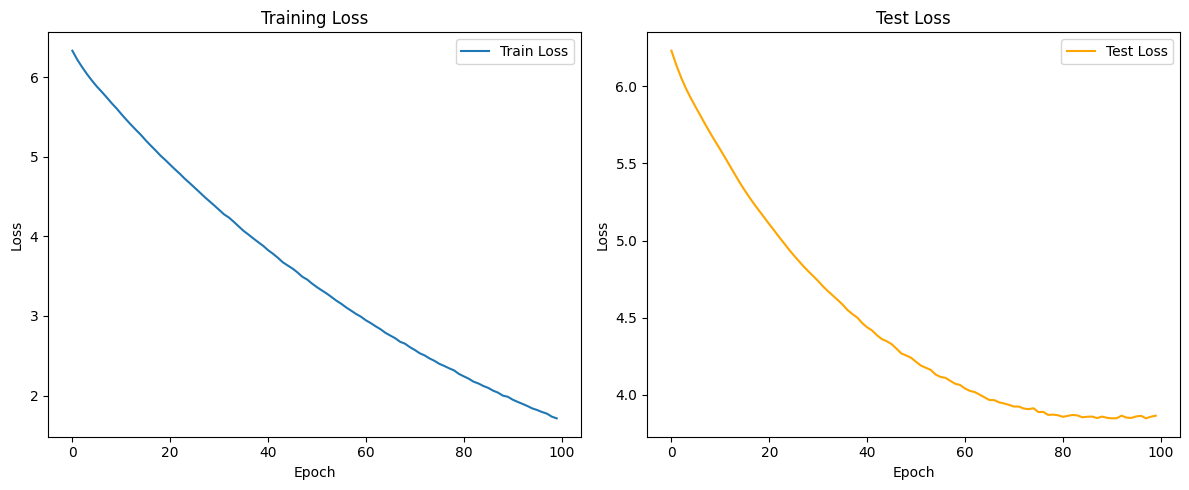


Пример 1
Промт: One day, a little
Сгенерированный текст: one day , a little fish loved to run and weak in the brown kayak . the forest saw a button his friends . they

Пример 2
Промт: The cat was
Сгенерированный текст: the cat was a girl named tim . for a triangle to in it liked to pretend she was run wanted to run

Пример 3
Промт: Once upon a time
Сгенерированный текст: once upon a time , there was a peaceful town . the crab had a little car . tim loved to his friend ,


In [8]:
def train_model(model, train_inputs, train_targets, test_inputs, test_targets, processor, device, epochs=5, batch_size=4, lr=0.001):
    model.to(device)  # модель на GPU
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        num_train_batches = 0
        
        train_indices = list(range(len(train_inputs)))
        random.shuffle(train_indices) # Перемешиваем данные каждый раз
        
        for i in range(0, len(train_indices), batch_size):
            batch_indices = train_indices[i:i + batch_size]
            
            input_seqs = []
            target_seqs = []
            for idx in batch_indices:
                input_seq = processor.text_to_sequence(train_inputs[idx], max_length=50)
                target_seq = processor.text_to_sequence(train_targets[idx], max_length=50)
                # Преобразует слова в токены
                input_seqs.append(input_seq)
                target_seqs.append(target_seq)
            
            input_tensor = torch.tensor(input_seqs, dtype=torch.long, device=device)
            target_tensor = torch.tensor(target_seqs, dtype=torch.long, device=device)
            
            optimizer.zero_grad()    # обнуляем градиенты с прошлого шага
            _, loss = model(input_tensor, target_tensor)  # прямой проход
            loss.backward()          # вычисление градиентов
            optimizer.step()         # обновление весов модели
                        
            total_train_loss += loss.item()
            num_train_batches += 1
            
            if num_train_batches % 50 == 0:
                print(f'Epoch {epoch+1}, Batch {num_train_batches}, Train Loss: {loss.item():.4f}')
        
        avg_train_loss = total_train_loss / num_train_batches
        train_losses.append(avg_train_loss)
        
        # Функция потерь на test
        model.eval()
        total_test_loss = 0
        num_test_batches = 0
        
        with torch.no_grad():
            test_indices = list(range(len(test_inputs)))
            
            for i in range(0, len(test_indices), batch_size):
                batch_indices = test_indices[i:i + batch_size]
                
                input_seqs = []
                target_seqs = []
                for idx in batch_indices:
                    input_seq = processor.text_to_sequence(test_inputs[idx], max_length=50)
                    target_seq = processor.text_to_sequence(test_targets[idx], max_length=50)
                    input_seqs.append(input_seq)
                    target_seqs.append(target_seq)
                
                input_tensor = torch.tensor(input_seqs, dtype=torch.long, device=device)
                target_tensor = torch.tensor(target_seqs, dtype=torch.long, device=device)
                
                _, loss = model(input_tensor, target_tensor)
                
                total_test_loss += loss.item()
                num_test_batches += 1
        
        avg_test_loss = total_test_loss / num_test_batches
        test_losses.append(avg_test_loss)
        
        print(f'Эпоха {epoch+1}. Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

test_inputs, test_targets = prepare_beginning_ending_pairs(test_stories)

# Обучение модели с тестовыми данными
train_losses, test_losses = train_model(
    model, 
    train_inputs,
    train_targets,
    test_inputs, 
    test_targets,
    processor,
    device,
    epochs=100,
    batch_size=50,
    lr=0.001
)

# Визуализация потерь
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Генерация текста
generator = StoryGenerator(model, processor, device)

test_prompts = [
    "One day, a little",
    "The cat was",
    "Once upon a time",
]

for i, prompt in enumerate(test_prompts):
    print(f"\nПример {i+1}")
    print(f"Промт: {prompt}")
    generated = generator.generate(prompt, max_length=20, temperature=0.8)
    print(f"Сгенерированный текст: {generated}")

In [9]:
print(f"Модель: {next(model.parameters()).device}")

Модель: cuda:0
